In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import datetime as dt
import pandas_ta as ta
import seaborn as sns
import itertools
from feature_engine.selection import DropHighPSIFeatures

import warnings
warnings.filterwarnings('ignore')

import MetaTrader5 as mt5
from data_labeling import raw_returns_labeling
from helper_functions import split_dates, data_import_MT5, drop_corr_features_target, plot_kde

# Set configuration

In [106]:
# Creamos un diccionario donde se definimos parametros de configuración

kwargs = dict()

kwargs['n_jobs'] = 10

kwargs['symbol'] = 'EURUSD'
kwargs['time_frame'] = mt5.TIMEFRAME_D1

In [107]:
# Definimos la dirección de la extracción

signal = 'shortonly'
if signal == 'longonly':
    kwargs['signal_direction'] = 'longonly'
    kwargs['type_bias'] = 'up'
else:
    kwargs['signal_direction'] = 'shortonly'
    kwargs['type_bias'] = 'down'

In [108]:
# Configuramos el etiquetado

kwargs['bias_extraction'] = True
kwargs['shift'] = 1
kwargs['bias'] = 0.001

In [109]:
# Configuramos los parámetros para la selección de caracteristicas

kwargs['corr_target'] = 0.01
kwargs['method_corr'] = 'pearson'

# Split Data

In [111]:
# Definimos la extensión en años y partición del conjunto de datos

kwargs['years_train_valid'] = 10
years_safe_date = 2

end_date = dt.datetime.now()
start_date = end_date - dt.timedelta(days=kwargs['years_train_valid'] * 365)
safe_start_date = start_date - dt.timedelta(days=years_safe_date * 365)
safe_start_date = dt.datetime.strftime(safe_start_date, "%Y-%m-%d")
start_date = dt.datetime.strftime(start_date, "%Y-%m-%d")
end_date = dt.datetime.strftime(end_date, "%Y-%m-%d")
oos_date = split_dates(start_date, end_date, 0.7)

kwargs['safe_start_date'] = safe_start_date
kwargs['start_date'] = start_date
kwargs['end_date'] = end_date
kwargs['oos_date'] = oos_date

# Load Data

In [112]:
# Cargamos los datos desde la api de metatrader

success = False
count_pass = 0
while not success and count_pass < 2:
    count_pass += 1
    try:
        data_symbol = data_import_MT5(symbol=kwargs['symbol'], 
                                        start=kwargs['safe_start_date'],
                                        end=kwargs['end_date'],
                                        time_frame=kwargs['time_frame'])
        data_symbol.drop(data_symbol.columns[4], axis=1, inplace=True)
        success  = True
    except:
        mt5.shutdown()
        success = False
        print("Error when trying load data from metatrader. Try load data again")
        pass

if not success:
    print("Error. Can't load data from metatrader")
else:
    print("Data load successful!")

Data load successful!


In [113]:
data_symbol.head()

,open,high,low,close
date,,,,
2012-09-27,1.28701,1.29275,1.28279,1.29139
2012-09-28,1.29117,1.29591,1.28382,1.28595
2012-10-01,1.28464,1.29382,1.28029,1.28860
2012-10-02,1.28873,1.29674,1.28797,1.29163
2012-10-03,1.29184,1.29364,1.28769,1.29085


# Labeling Data



In [114]:
# Creamos la etiqueta a predecir

data_symbol = raw_returns_labeling(data_ohlc=data_symbol, **kwargs)

label_counts = data_symbol['LABEL'].value_counts()

data_label = data_symbol['LABEL']
data_label = data_label.replace('UP', 1).replace('DOWN', 0) \
    if signal == 'longonly' \
        else data_label.replace('UP', 0).replace('DOWN', 1)
        
data_label = data_label[data_label.index > kwargs['start_date']]

print(f'Label {label_counts.index[0]} = {label_counts.iloc[0]}')
print(f'Label {label_counts.index[1]} = {label_counts.iloc[1]}')

Label UP = 1870
Label DOWN = 1242


In [115]:
data_label.head()

date
2014-09-29    0
2014-09-30    1
2014-10-01    0
2014-10-02    0
2014-10-03    1
Name: LABEL, dtype: int64

# Create Features

In [116]:
# Creamos un dataframe con el indicador rsi de 2-100 periodos
# Calculamos la carrelación de cada periodo del indicador con la variable target

calc_indicator = list()
calc_correlation = list()

for length in range(2, 100):
    indicator_value = ta.rsi(data_symbol.close.shift(1), length).rename(length)
    corr_value = indicator_value.to_frame().corrwith(data_label, method=kwargs['method_corr']).abs()
    calc_indicator.append(indicator_value)
    calc_correlation.append(corr_value)

data_indicator = pd.concat(calc_indicator, axis=1).dropna()

data_indicator = data_indicator[data_indicator.index > kwargs['start_date']]

data_indicator.head()

,2,3,4,5,6,7,8,9,10,11,...,90,91,92,93,94,95,96,97,98,99
date,,,,,,,,,,,,,,,,,,,,,
2014-09-29,2.471464,8.124516,12.771078,15.985275,18.163301,19.664293,20.729060,21.509912,22.102899,22.569477,...,37.174682,37.300929,37.425463,37.548299,37.669455,37.788946,37.906792,38.023010,38.137619,38.250636
2014-09-30,12.668442,13.500100,16.313638,18.604147,20.240988,21.391699,22.213082,22.815632,23.272543,23.631839,...,37.309938,37.434381,37.557151,37.678265,37.797736,37.915583,38.031820,38.146465,38.259535,38.371048
2014-10-01,4.285428,7.413484,10.828395,13.634342,15.751703,17.325758,18.508597,19.416321,20.130697,20.708152,...,36.565243,36.695608,36.824216,36.951084,37.076229,37.199668,37.321419,37.441502,37.559933,37.676733
2014-10-02,3.352232,6.490228,9.895263,12.739544,14.916622,16.553633,17.795177,18.755077,19.514956,20.131861,...,36.410659,36.542229,36.672026,36.800066,36.926368,37.050947,37.173824,37.295016,37.414542,37.532422
2014-10-03,65.778573,47.538382,39.170161,35.055081,32.818333,31.476234,30.600262,29.989961,29.544327,29.208692,...,37.529292,37.645993,37.761259,37.875099,37.987521,38.098532,38.208143,38.316363,38.423204,38.528675


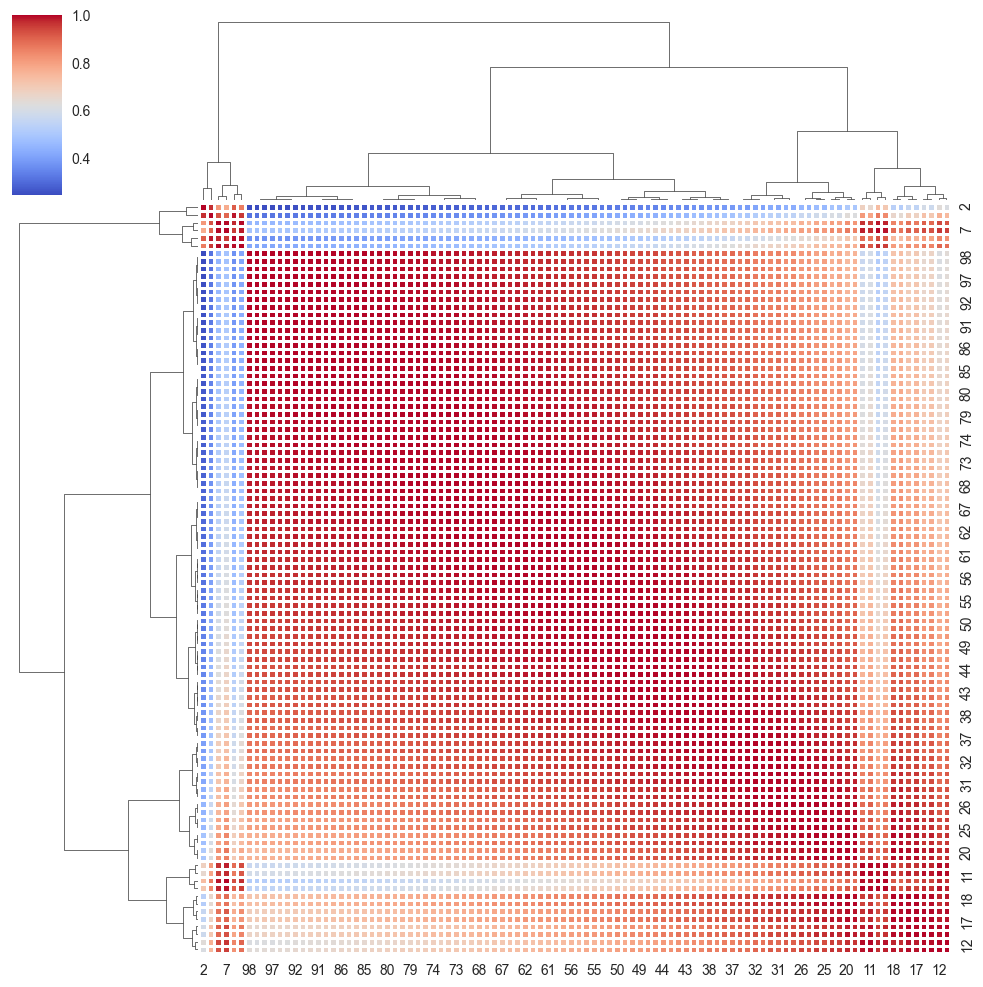

In [117]:
# Creamos gráfico de correlación

corr_indicator = data_indicator.corr()
sns.clustermap(corr_indicator, cmap='coolwarm', linewidth=1, method='ward')

In [118]:
data_indicator_t = data_indicator.T
data_indicator_t

date,2014-09-29,2014-09-30,2014-10-01,2014-10-02,2014-10-03,2014-10-06,2014-10-07,2014-10-08,2014-10-09,2014-10-10,...,2024-09-10,2024-09-11,2024-09-12,2024-09-13,2024-09-16,2024-09-17,2024-09-18,2024-09-19,2024-09-20,2024-09-23
2,2.471464,12.668442,4.285428,3.352232,65.778573,13.366909,64.306385,67.397839,83.841738,51.530656,...,15.975167,11.481347,8.897685,80.075475,80.075475,94.817600,64.454537,68.510022,91.463569,91.871264
3,8.124516,13.500100,7.413484,6.490228,47.538382,15.853698,55.603522,58.003045,71.552456,55.006107,...,26.253508,21.703283,19.135621,66.426795,66.426795,84.723700,67.228481,69.150001,84.850661,85.238359
4,12.771078,16.313638,10.828395,9.895263,39.170161,16.921226,50.496472,52.557806,64.226461,53.351269,...,31.667159,27.728577,25.542380,59.410786,59.410786,76.620015,64.934337,66.311898,79.169354,79.527770
5,15.985275,18.604147,13.634342,12.739544,35.055081,17.792056,47.006126,48.838635,59.199650,51.151021,...,35.438511,32.024119,30.150014,55.809175,55.809175,70.974002,62.446645,63.547515,74.540791,74.866751
6,18.163301,20.240988,15.751703,14.916622,32.818333,18.579842,44.470493,46.128058,55.494055,49.123733,...,38.414344,35.400290,33.759715,54.045188,54.045188,67.207974,60.579498,61.495856,71.021351,71.314326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,37.788946,37.915583,37.199668,37.050947,38.098532,36.248105,38.932581,39.141414,40.352530,39.854298,...,52.945516,52.661332,52.514303,53.554542,53.554542,54.481592,54.133964,54.193362,54.889098,54.912909
96,37.906792,38.031820,37.321419,37.173824,38.208143,36.371545,39.024042,39.230463,40.427737,39.933551,...,52.924260,52.643345,52.498010,53.527109,53.527109,54.444461,54.100920,54.159696,54.848201,54.871766
97,38.023010,38.146465,37.441502,37.295016,38.316363,36.493403,39.114585,39.318641,40.502349,40.012143,...,52.903242,52.625531,52.481857,53.500026,53.500026,54.407858,54.068321,54.126488,54.807895,54.831218
98,38.137619,38.259535,37.559933,37.414542,38.423204,36.613694,39.204206,39.405945,40.576356,40.090064,...,52.882460,52.607889,52.465842,53.473286,53.473286,54.371773,54.036161,54.093728,54.768165,54.791251


In [119]:
data_correlation = pd.concat(calc_correlation, axis=0)
data_correlation

2     0.051430
3     0.053831
4     0.052866
5     0.050811
6     0.048432
        ...   
95    0.020264
96    0.020473
97    0.020677
98    0.020877
99    0.021073
Length: 98, dtype: float64

In [120]:
# Escalamos los datos

data_indicator_norm = (data_indicator_t - data_indicator_t.min()) \
        / (data_indicator_t.max() - data_indicator_t.min())

data_indicator_norm

date,2014-09-29,2014-09-30,2014-10-01,2014-10-02,2014-10-03,2014-10-06,2014-10-07,2014-10-08,2014-10-09,2014-10-10,...,2024-09-10,2024-09-11,2024-09-12,2024-09-13,2024-09-16,2024-09-17,2024-09-18,2024-09-19,2024-09-20,2024-09-23
2,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.819563,...,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.790235,0.957585,1.000000,1.000000
3,0.157998,0.032357,0.093679,0.091807,0.513409,0.106430,0.720040,0.720537,0.739284,1.000000,...,0.268603,0.242783,0.230730,0.495354,0.495354,0.750653,1.000000,1.000000,0.819981,0.821309
4,0.287866,0.141822,0.195948,0.191428,0.290171,0.152118,0.555752,0.558560,0.583864,0.914085,...,0.410078,0.385891,0.375118,0.235945,0.235945,0.550471,0.826517,0.811904,0.665323,0.667465
5,0.377700,0.230938,0.279981,0.274642,0.180393,0.189388,0.443472,0.447928,0.477220,0.799853,...,0.508635,0.487916,0.478960,0.102779,0.102779,0.410999,0.638399,0.628694,0.539323,0.541897
6,0.438575,0.294622,0.343391,0.338336,0.120724,0.223104,0.361904,0.367297,0.398606,0.694601,...,0.586402,0.568104,0.560311,0.037558,0.037558,0.317968,0.497205,0.492720,0.443515,0.446194
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.987096,0.982279,0.985713,0.985914,0.261583,0.979272,0.183756,0.159469,0.077380,0.213353,...,0.966144,0.978075,0.982979,0.019417,0.019417,0.003592,0.009795,0.008745,0.004358,0.004339
96,0.990390,0.986802,0.989359,0.989509,0.264507,0.984555,0.186698,0.162118,0.078976,0.217468,...,0.965589,0.977648,0.982612,0.018402,0.018402,0.002674,0.007297,0.006514,0.003245,0.003230
97,0.993638,0.991262,0.992955,0.993054,0.267394,0.989770,0.189611,0.164741,0.080559,0.221548,...,0.965039,0.977224,0.982248,0.017401,0.017401,0.001770,0.004832,0.004313,0.002148,0.002138
98,0.996841,0.995661,0.996502,0.996551,0.270244,0.994918,0.192494,0.167338,0.082129,0.225594,...,0.964496,0.976805,0.981887,0.016412,0.016412,0.000879,0.002400,0.002142,0.001066,0.001061


# Clusterize

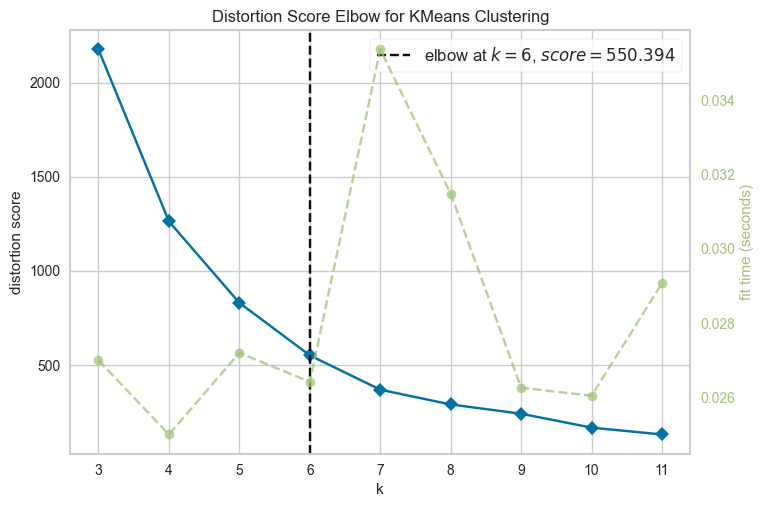

In [121]:
# Se aplica el método del elbow (método del codo), para determinar el número de cluster óptimo

method_cluster = 'kmeans'

if method_cluster == 'kmeans':
    kmeans = KMeans(init='k-means++', 
                    n_init='auto', 
                    max_iter=300, 
                    tol=0.0001,  
                    random_state=42).fit(data_indicator_norm)
if method_cluster == 'MiniBatchKMeans':
    kmeans = MiniBatchKMeans(
        init="k-means++",
        n_init=10,
        batch_size=512,
        max_no_improvement=10,
        verbose=0,
        random_state=42).fit(data_indicator_norm)
    
from yellowbrick.cluster import KElbowVisualizer

visualizer = KElbowVisualizer(kmeans, k=(3,12))

visualizer.fit(data_indicator_norm)       
visualizer.show()   

k_cluster = visualizer.elbow_value_

In [122]:
# Aplicamos clusterización y etiquetamos los periodos del indicador

method_cluster = 'kmeans'

if method_cluster == 'kmeans':
    kmeans = KMeans(n_clusters=k_cluster, 
                    init='k-means++', 
                    n_init='auto', 
                    max_iter=300, 
                    tol=0.0001,  
                    random_state=42).fit(data_indicator_norm)
    cluster_labels = kmeans.labels_
if method_cluster == 'MiniBatchKMeans':
    kmeans = MiniBatchKMeans(
        init="k-means++",
        n_clusters=k_cluster,
        n_init=10,
        batch_size=512,
        max_no_improvement=10,
        verbose=0,
        random_state=42).fit(data_indicator_norm)
    cluster_labels = kmeans.labels_
if method_cluster == 'gmm':
    gmm = GaussianMixture(n_components=k_cluster, random_state=42)
    gmm.fit(data_indicator_norm)
    cluster_labels = gmm.predict(data_indicator_norm)

data_indicator_t['cluster_labels'] = cluster_labels

In [89]:
data_indicator_t

date,2014-09-29 00:00:00,2014-09-30 00:00:00,2014-10-01 00:00:00,2014-10-02 00:00:00,2014-10-03 00:00:00,2014-10-06 00:00:00,2014-10-07 00:00:00,2014-10-08 00:00:00,2014-10-09 00:00:00,2014-10-10 00:00:00,...,2024-09-11 00:00:00,2024-09-12 00:00:00,2024-09-13 00:00:00,2024-09-16 00:00:00,2024-09-17 00:00:00,2024-09-18 00:00:00,2024-09-19 00:00:00,2024-09-20 00:00:00,2024-09-23 00:00:00,cluster_labels
2,2.471464,12.668442,4.285428,3.352232,65.778573,13.366909,64.306385,67.397839,83.841738,51.530656,...,11.481347,8.897685,80.075475,80.075475,94.817600,64.454537,68.510022,91.463569,91.871264,2
3,8.124516,13.500100,7.413484,6.490228,47.538382,15.853698,55.603522,58.003045,71.552456,55.006107,...,21.703283,19.135621,66.426795,66.426795,84.723700,67.228481,69.150001,84.850661,85.238359,5
4,12.771078,16.313638,10.828395,9.895263,39.170161,16.921226,50.496472,52.557806,64.226461,53.351269,...,27.728577,25.542380,59.410786,59.410786,76.620015,64.934337,66.311898,79.169354,79.527770,5
5,15.985275,18.604147,13.634342,12.739544,35.055081,17.792056,47.006126,48.838635,59.199650,51.151021,...,32.024119,30.150014,55.809175,55.809175,70.974002,62.446645,63.547515,74.540791,74.866751,1
6,18.163301,20.240988,15.751703,14.916622,32.818333,18.579842,44.470493,46.128058,55.494055,49.123733,...,35.400290,33.759715,54.045188,54.045188,67.207974,60.579498,61.495856,71.021351,71.314326,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,37.788946,37.915583,37.199668,37.050947,38.098532,36.248105,38.932581,39.141414,40.352530,39.854298,...,52.661332,52.514303,53.554542,53.554542,54.481592,54.133964,54.193362,54.889098,54.912909,3
96,37.906792,38.031820,37.321419,37.173824,38.208143,36.371545,39.024042,39.230463,40.427737,39.933551,...,52.643345,52.498010,53.527109,53.527109,54.444461,54.100920,54.159696,54.848201,54.871766,3
97,38.023010,38.146465,37.441502,37.295016,38.316363,36.493403,39.114585,39.318641,40.502349,40.012143,...,52.625531,52.481857,53.500026,53.500026,54.407858,54.068321,54.126488,54.807895,54.831218,3
98,38.137619,38.259535,37.559933,37.414542,38.423204,36.613694,39.204206,39.405945,40.576356,40.090064,...,52.607889,52.465842,53.473286,53.473286,54.371773,54.036161,54.093728,54.768165,54.791251,3


In [123]:
# Obtemos los rangos del indicador en cada cluster

range_length = list()

for item_cluster in range(k_cluster):
    range_length.append(data_indicator_t[data_indicator_t['cluster_labels'] == item_cluster].index)

range_length_df = pd.DataFrame(range_length)

In [124]:
# Contamos cuantos elementos tiene cada cluster

elements_cluster = range_length_df.count(axis=1)

In [125]:
# Creamos dataframe que resume el rango max y min del periodo del indicador
# número de elementos de cada cluster

count_min_max_length = pd.concat([elements_cluster, range_length_df.min(axis=1), range_length_df.max(axis=1)], axis=1)
count_min_max_length.columns = ['elements_cluster', 'min', 'max']
count_min_max_length

,elements_cluster,min,max
0,27,26.0,52.0
1,7,5.0,11.0
2,1,2.0,2.0
3,47,53.0,99.0
4,14,12.0,25.0
5,2,3.0,4.0


In [126]:
# Determinamos en cada cluster el valor promedio del valor de la correlación con el target

mean_cluster_range_length = list()    
for items_range in range_length:
    mean_corr_cluster = data_correlation.filter(items=items_range, axis=0).mean()
    mean_cluster_range_length.append(mean_corr_cluster)

mean_cluster_range_length_df = pd.DataFrame(mean_cluster_range_length, columns=['rank_cluster_corr'])

mean_cluster_range_length_df

,rank_cluster_corr
0,0.006221
1,0.043917
2,0.051430
3,0.014519
4,0.025823
5,0.053349


# Best period Cluster

In [127]:
# De cada cluster seleccionamos el periodo que tenga mayor correlación con la variable objetivo

instances = 1

best_length_cluster_corr = list()
for items_range in range_length:
    select_best = data_correlation.filter(items=items_range, axis=0).sort_values(ascending=False).head(instances)
    best_length_cluster_corr.append(select_best)

best_features = pd.concat(best_length_cluster_corr)

best_features

26    0.016241
5     0.050811
2     0.051430
99    0.021073
12    0.035622
3     0.053831
dtype: float64

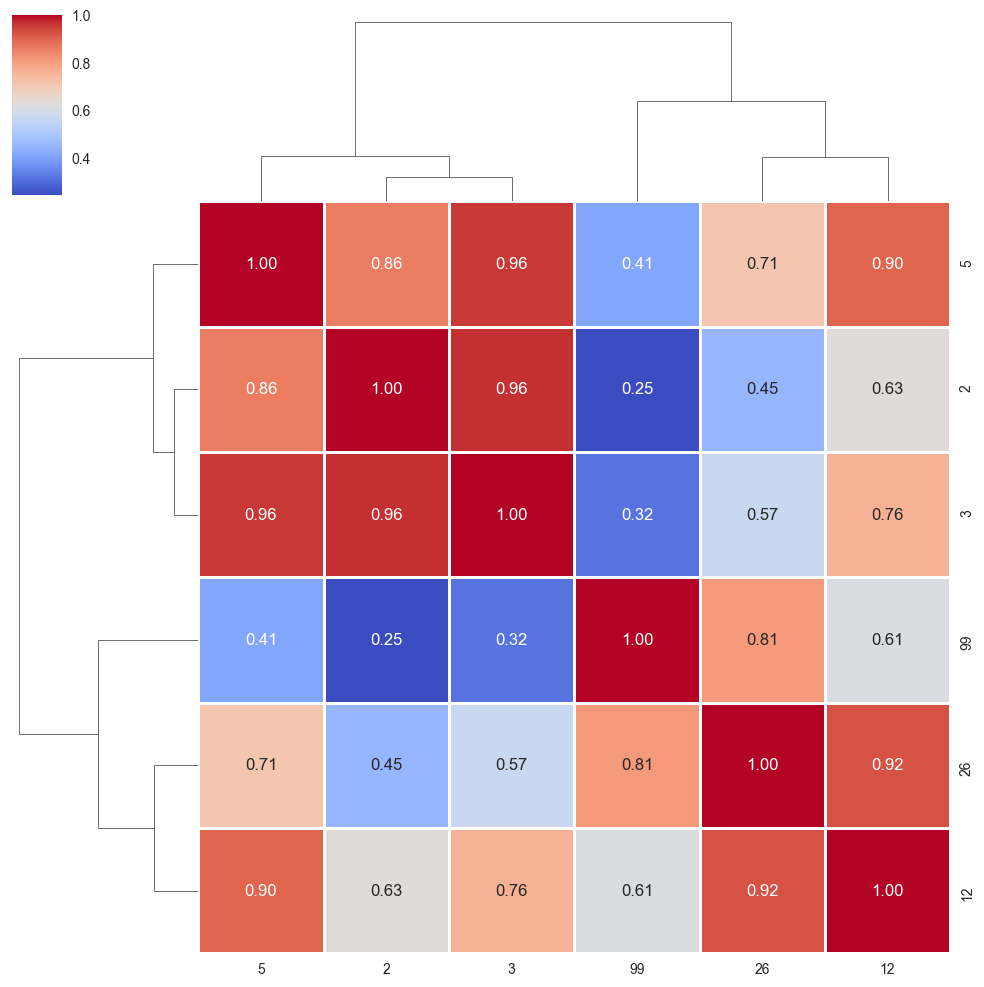

In [128]:
# Creamos gráfico de correlación

data_indicator_best = data_indicator.loc[:, best_features.index]

corr_matrix = data_indicator_best.corr()
sns.clustermap(corr_matrix, cmap='coolwarm', linewidth=1, method='ward', annot=True, fmt=".2f")

In [129]:
data_indicator_best

,26,5,2,99,12,3
date,,,,,,
2014-09-29,25.966306,15.985275,2.471464,38.250636,22.949724,8.124516
2014-09-30,26.453691,18.604147,12.668442,38.371048,23.925245,13.500100
2014-10-01,24.861348,13.634342,4.285428,37.676733,21.187646,7.413484
2014-10-02,24.538231,12.739544,3.352232,37.532422,20.645569,6.490228
2014-10-03,28.581559,35.055081,65.778573,38.528675,28.951402,47.538382
...,...,...,...,...,...,...
2024-09-17,58.784385,70.974002,94.817600,54.336195,60.339555,84.723700
2024-09-18,57.470128,62.446645,64.454537,54.004428,57.492209,67.228481
2024-09-19,57.668055,63.547515,68.510022,54.061407,57.927727,69.150001


# Best period drop correlation

In [130]:
# Usamos el metodo de correlación entre indicadore y correlación con el target
# Para seleccionar los indicadores menos correlacionados entre sí y que tengan
# mayor correlación con la variable target

cols_to_drop = list()
for item_range in range_length:
    cols = drop_corr_features_target(data_features=data_indicator.loc[:, item_range],
                                     data_corr=data_correlation.filter(items=item_range, axis=0),
                                     threshold_corr=0.85,
                                     n_cpus=8)
    cols_to_drop.append(cols)

In [131]:
cols_to_drop = list(itertools.chain.from_iterable(cols_to_drop))

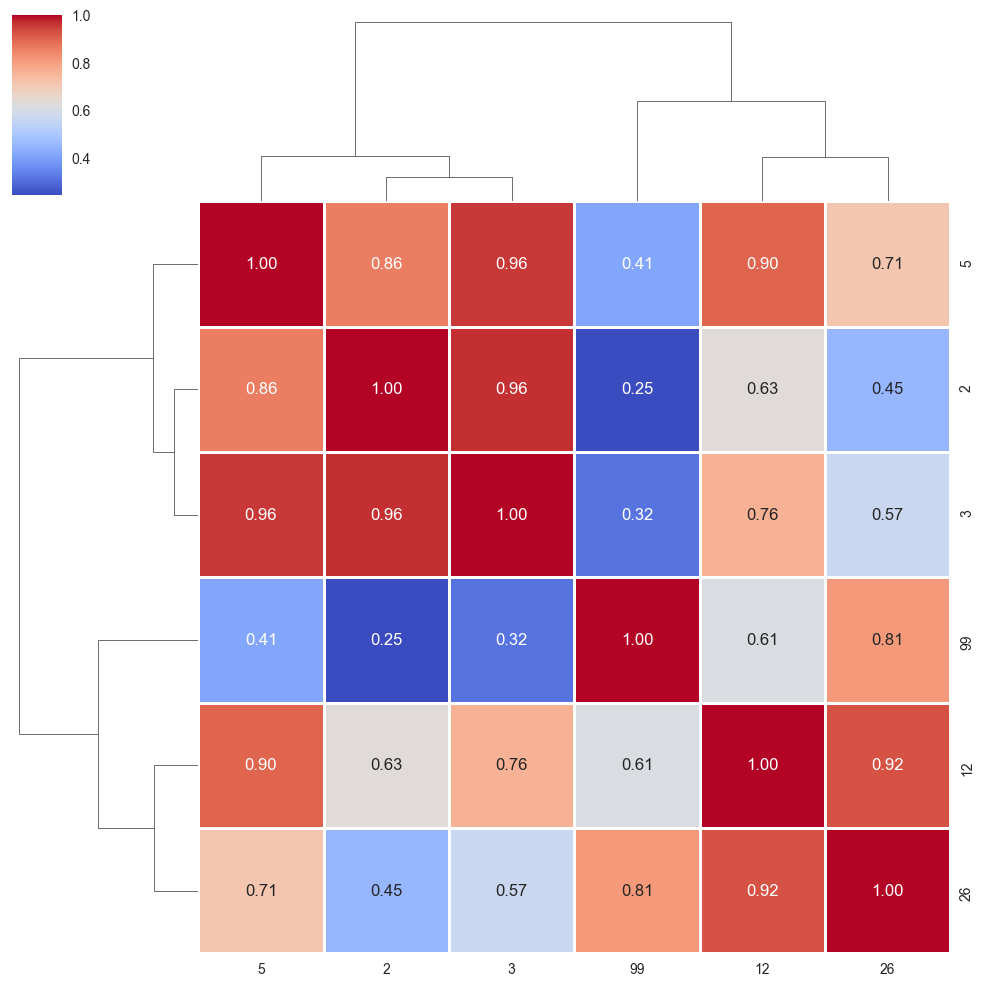

In [134]:
# Creamos gráfico de correlación

data_indicator_uncorr = data_indicator.drop(cols_to_drop, axis=1)

corr_matrix = data_indicator_uncorr.corr()
sns.clustermap(corr_matrix, cmap='coolwarm', linewidth=1, method='ward', annot=True, fmt=".2f")

In [135]:
data_indicator_uncorr

,2,3,5,12,26,99
date,,,,,,
2014-09-29,2.471464,8.124516,15.985275,22.949724,25.966306,38.250636
2014-09-30,12.668442,13.500100,18.604147,23.925245,26.453691,38.371048
2014-10-01,4.285428,7.413484,13.634342,21.187646,24.861348,37.676733
2014-10-02,3.352232,6.490228,12.739544,20.645569,24.538231,37.532422
2014-10-03,65.778573,47.538382,35.055081,28.951402,28.581559,38.528675
...,...,...,...,...,...,...
2024-09-17,94.817600,84.723700,70.974002,60.339555,58.784385,54.336195
2024-09-18,64.454537,67.228481,62.446645,57.492209,57.470128,54.004428
2024-09-19,68.510022,69.150001,63.547515,57.927727,57.668055,54.061407


# PSI Test

In [136]:
# Aplicamos la técnica PSI para determinar el drift en los periodos del indicador
# Definimos un umbral de 0.25. Por arriba de este valor, se concluye que la función
# de distribución del indicador entre las ventans de train y test ha variado considerablemente.

psi = DropHighPSIFeatures(threshold=0.25, split_frac=0.7)

X_selected = psi.fit_transform(data_indicator_best)
features_to_drop = psi.features_to_drop_
psi_values = pd.DataFrame([psi.psi_values_]).T.sort_values(by=[0], ascending=False)

psi_values

,0
99,0.781228
26,0.042740
12,0.033196
5,0.009735
3,0.009148
2,0.006249


In [137]:
X_train = data_indicator_best[data_indicator_best.index < kwargs['oos_date']]
X_test = data_indicator_best[data_indicator_best.index >= kwargs['oos_date']]

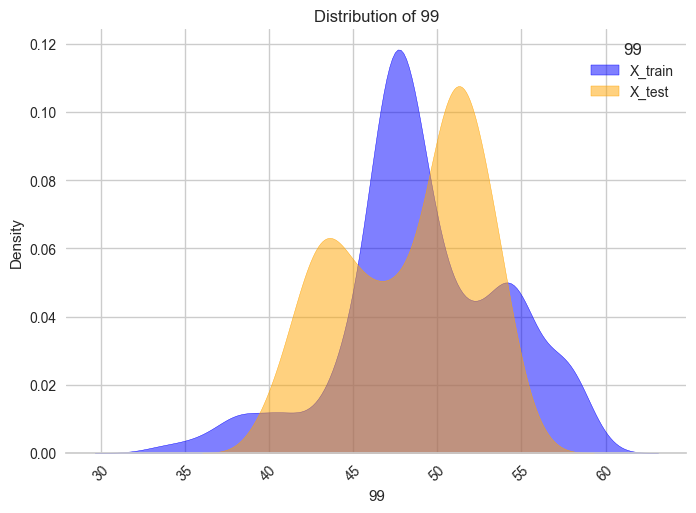

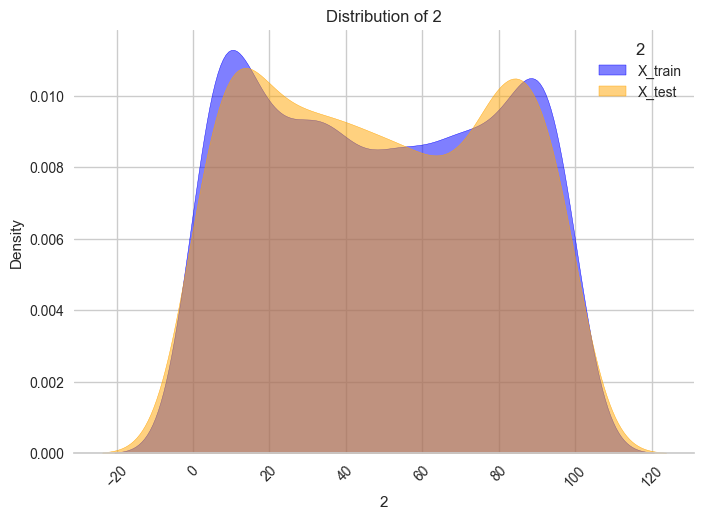

In [138]:
# Graficos las funciones de distribución 

worst_feature_psi = psi_values.idxmax()[0]
plot_kde(X_train, X_test, worst_feature_psi)

best_feature_psi = psi_values.idxmin()[0]
plot_kde(X_train, X_test, best_feature_psi)

In [139]:
X_selected

,26,5,2,12,3
date,,,,,
2014-09-29,25.966306,15.985275,2.471464,22.949724,8.124516
2014-09-30,26.453691,18.604147,12.668442,23.925245,13.500100
2014-10-01,24.861348,13.634342,4.285428,21.187646,7.413484
2014-10-02,24.538231,12.739544,3.352232,20.645569,6.490228
2014-10-03,28.581559,35.055081,65.778573,28.951402,47.538382
...,...,...,...,...,...
2024-09-17,58.784385,70.974002,94.817600,60.339555,84.723700
2024-09-18,57.470128,62.446645,64.454537,57.492209,67.228481
2024-09-19,57.668055,63.547515,68.510022,57.927727,69.150001
